# King County Housing Data Analysis

In [1]:
# Import packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import math
%matplotlib inline
import scipy.stats as stats
import statsmodels.formula.api as sm

## Data: 
King County House Sales dataset is downloaded from Kaggle Website. 
The goal of the project is to explore the data and create predictive models to predict house prices given features like location, square footage, construction quality and construction time.


In [2]:
# Import Data, convert and create new features
file_name = 'kc_house_data.csv'
df = pd.read_csv(file_name)
df['date'] = pd.to_datetime(df['date'])    # convert DateFormat type to Datetime object 
df['price_per_sqft'] = df['price'] / df['sqft_living']    # Add price per square foot column
df['log_price'] = np.log(df['price'])      # add log(price) column to dataframe for ease of use 

# Create zone column. Unincorporated areas are assigned to zone 0 and other areas are assigned to zone 1. ( zone column will be refined later)
# Zone-1: Seattle (West Side)
zone1 = [98177,98160,98155,98133,98125,98115,98103,98117,98107,98185,98105,98145,98195,98102,98199,98119,98109,98112,98191,98181,98154,98164,98121,98101,98104,98122,98144,98134,98124,98116,98126,98136,98106,98108,98118,98040]
# Zone-2: Bellevue (East Side)
zone2 = [98028,98011,98041,98072,98034,98052,98033,98009,98015,98004,98005,98007,98008,98006,98027,98083,98050]
# Zone-3: Auburn (South Side)
zone3 = [98146,98166,98198,98023,98168,98178,98056,98057,98055,98148,98158,98188,98138,98032,98031,98035,98064,98030,98092,98002,98047,98071,98093,98001,98063,98062]

# set all the zone numbers to 4 (Far East Side - Sammamish)
df['zone'] = 4
df.loc[df['zipcode'].isin(zone1),'zone'] = 1
df.loc[df['zipcode'].isin(zone2),'zone'] = 2
df.loc[df['zipcode'].isin(zone3),'zone'] = 3

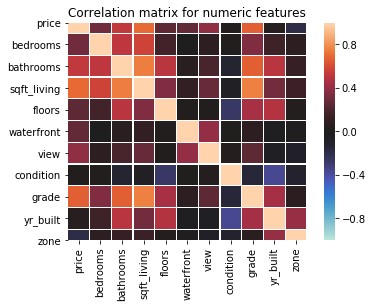

In [3]:
# Create Correlation Matrix and corresponding heatmap for non-categorical data (location data are excluded)
auto_corr = df[['price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors','waterfront', 'view', 'condition', 'grade','yr_built', 'zone']].corr()
sns.heatmap(auto_corr, vmax=1.0, vmin = -1.0, center=0, 
            square=True, linewidths=.25, cbar_kws={"shrink": 1.0})
plt.title('Correlation matrix for numeric features')
plt.yticks(rotation='horizontal')
plt.xticks(rotation='vertical')
plt.show()

From correlation matrix, the area of the house and grade have high correlation with the price of the house. The availability of grade data before construction of the house is questionable. 

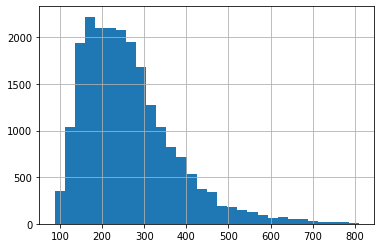

In [5]:
# Convert latitude and longitude data to X and Y for each zipcode (
#zipcode_data = df.loc[:,['zipcode', 'lat', 'long', 'price_per_sft']].groupby('zipcode').mean()
basepoint = np.min(df.loc[:,  ['lat','long']])
df['X'] = 0;
df['Y'] = 0;
df.loc[:,'X'] = (df.loc[:,'long'] - basepoint['long'])*40000*np.cos((df.loc[:,'lat'] + basepoint['lat'])*math.pi/360)/360
df.loc[:,'Y'] = (df.loc[:,'lat'] - basepoint['lat'])*40000/360
#for i in range(df.shape[0]):
#    df[i]['X'] = (df.iloc[i]['long'] - basepoint['long'])*40000*math.cos((df.iloc[i]['lat'] + basepoint['lat'])*math.pi/360)/360
#    df[i]['Y'] = (df.iloc[i]['lat'] - basepoint['lat'])*40000/360
price_cat_bins = [0,100,150,175,200,225,250,275,300,325,350,375,400,450,500,600,700,850]
df['price_cat'] = pd.cut(df['price_per_sqft'], price_cat_bins)
df.price_per_sqft.hist(bins = 30)
plt.show()

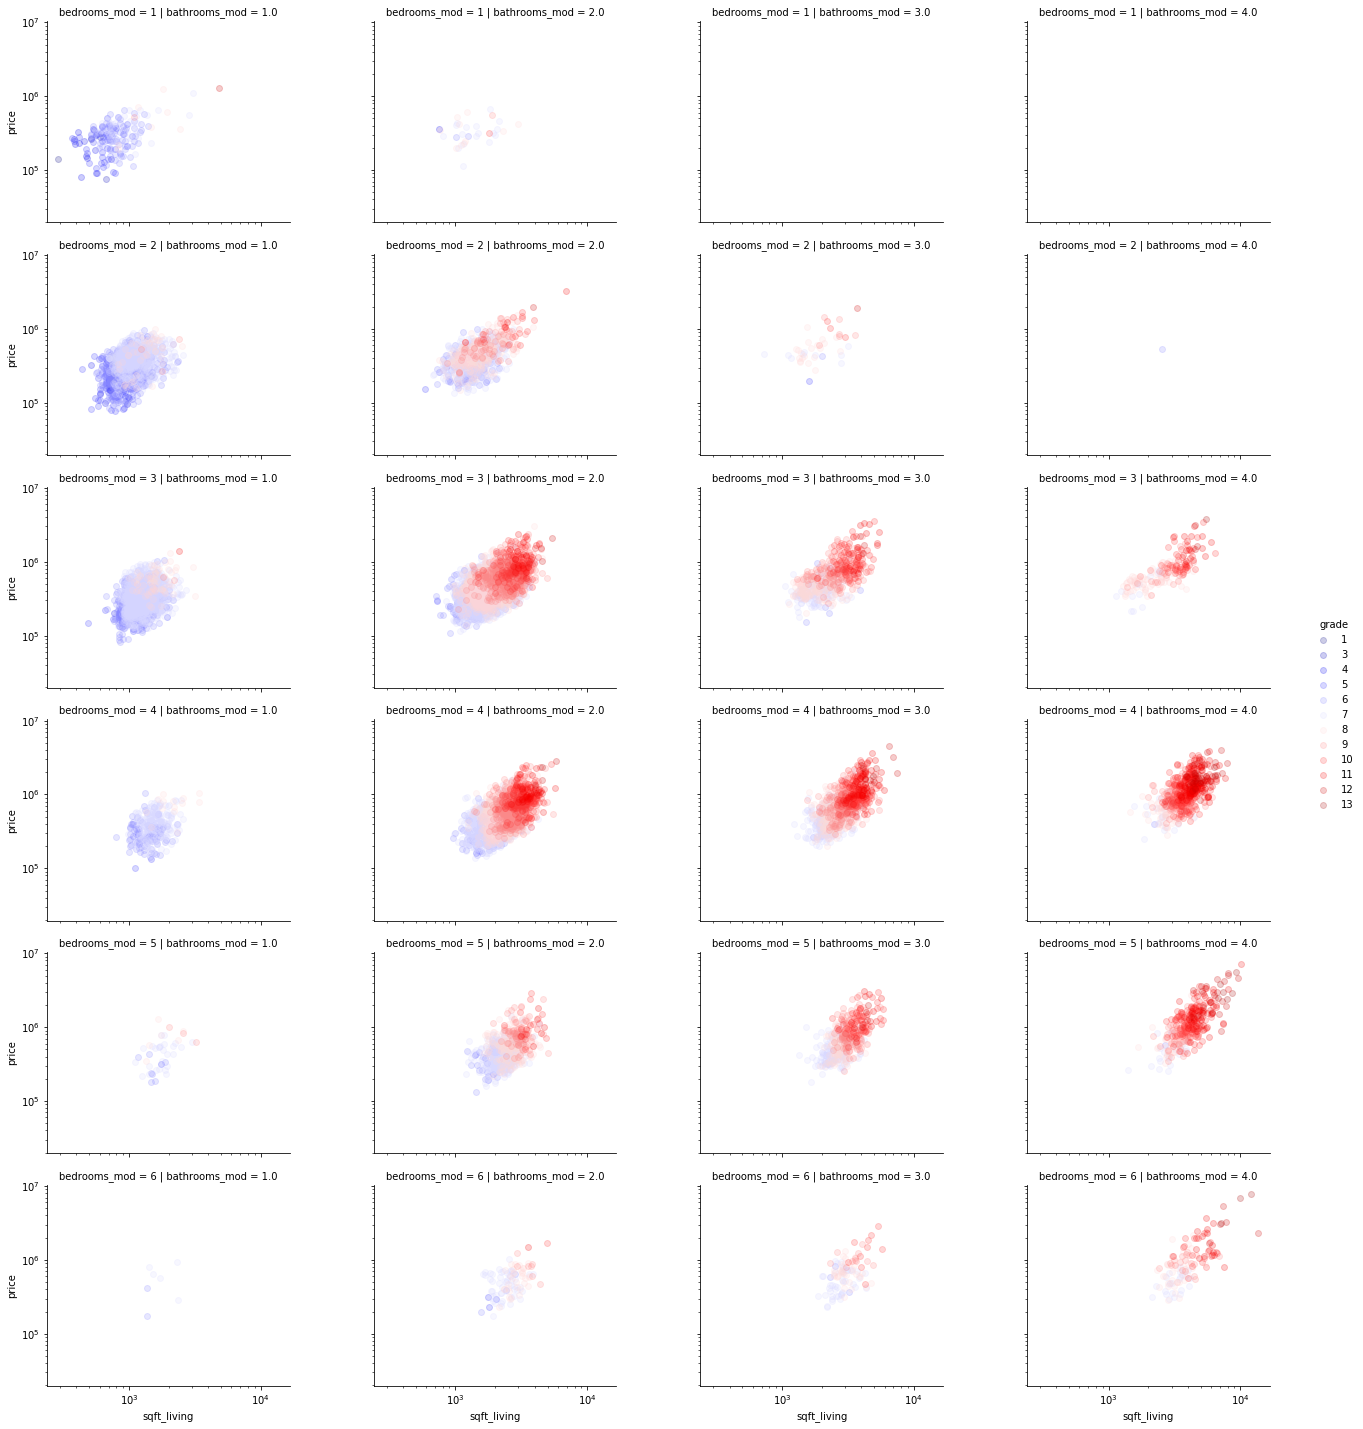

In [6]:
# Create grid plot for price of the house vs living area for different number of bedrooms and bathrooms
# Number of bedrooms are limited between 1 and 6 bedrooms; Number of bedrooms for houses with out-of-limits 
# number of bedrooms are modified to reflect the limiting values (1 or 6). Same approach is used for the number of 
# bathrooms with limiting values of minimum 1 and maximum 4 bathrooms.
#
df['bedrooms_mod'] = df['bedrooms']*1
df.loc[df['bedrooms_mod']>=6,'bedrooms_mod'] = 6; 
df.loc[df['bedrooms_mod']<1,'bedrooms_mod'] = 1;
df['bathrooms_mod'] = np.round(df['bathrooms']*1)
df.loc[df['bathrooms_mod']>=4,'bathrooms_mod'] = 4;
df.loc[df['bathrooms_mod']< 1,'bathrooms_mod'] = 1;
df['view/waterfront'] = (df.loc[:,'view'] > 0.0) | (df.loc[:,'waterfront'] > 0.0)
g = sns.FacetGrid(df, col='bathrooms_mod', row='bedrooms_mod',  hue='grade', palette="seismic")
g = (g.map(plt.scatter, 'sqft_living','price', alpha = 0.2)
     .add_legend())
g.set(xscale="log", yscale="log")
fig = plt.gcf()
fig.set_size_inches(20,20)

- Grade of house is a number between 1 and 13 and is assigned by King County assessors to each house. The higher the grade the better the quality of the house (in terms of material, location and construction). 
- One and two bedroom houses are less likely to be graded 10.
- Majority of houses with three bedrooms or more are graded above grade 10. 
- In some houses with similar area and number of bedrooms, number of bathrooms can impact the grade and price of the house (in each row of the grid plot, note the upward trend in the price of the houses from left to right).

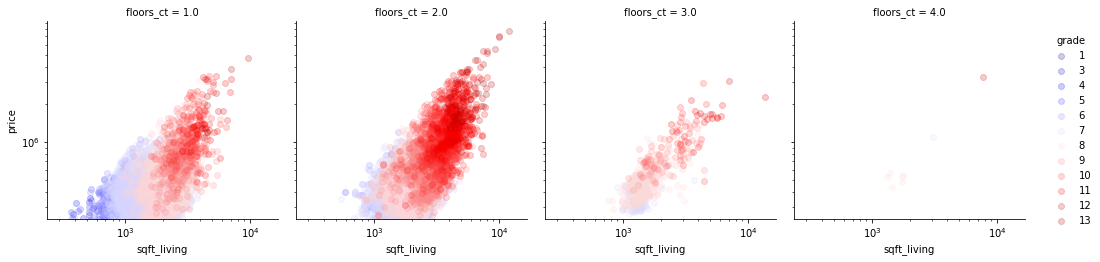

In [7]:
# Create the grid plot to investigate the impact of the number of floors on price vs area trend. 
# To limit the number of plots, floor numbers are rounded. 
df['floors_ct'] = np.round(df['floors']*1)
g = sns.FacetGrid(df, col='floors_ct',  palette="seismic", hue = 'grade')
g = (g.map(plt.scatter, 'sqft_living','price', alpha = 0.2 )
     .add_legend())
g.set(xscale="log", yscale="log")
fig = plt.gcf()
fig.set_size_inches(16,4)

- For certain price, range of area and grade of the houses increases as the number of floors increases. There is a  relatively large population of single-floor houses with grades less than 7 and wide sqft_living range (first subplot on the left). They seem to be older houses in less congested areas (larger lot sizes). (To be investigated further). 
- Majority of two and three-floor houses are highly graded (10 and above) and seem to have higher prices compared to the first group). 
- The distribution of price for certain sqft_living is narrower for three-floor houses compared to one and two-floor houses.

/Users/reza/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/Users/reza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/reza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


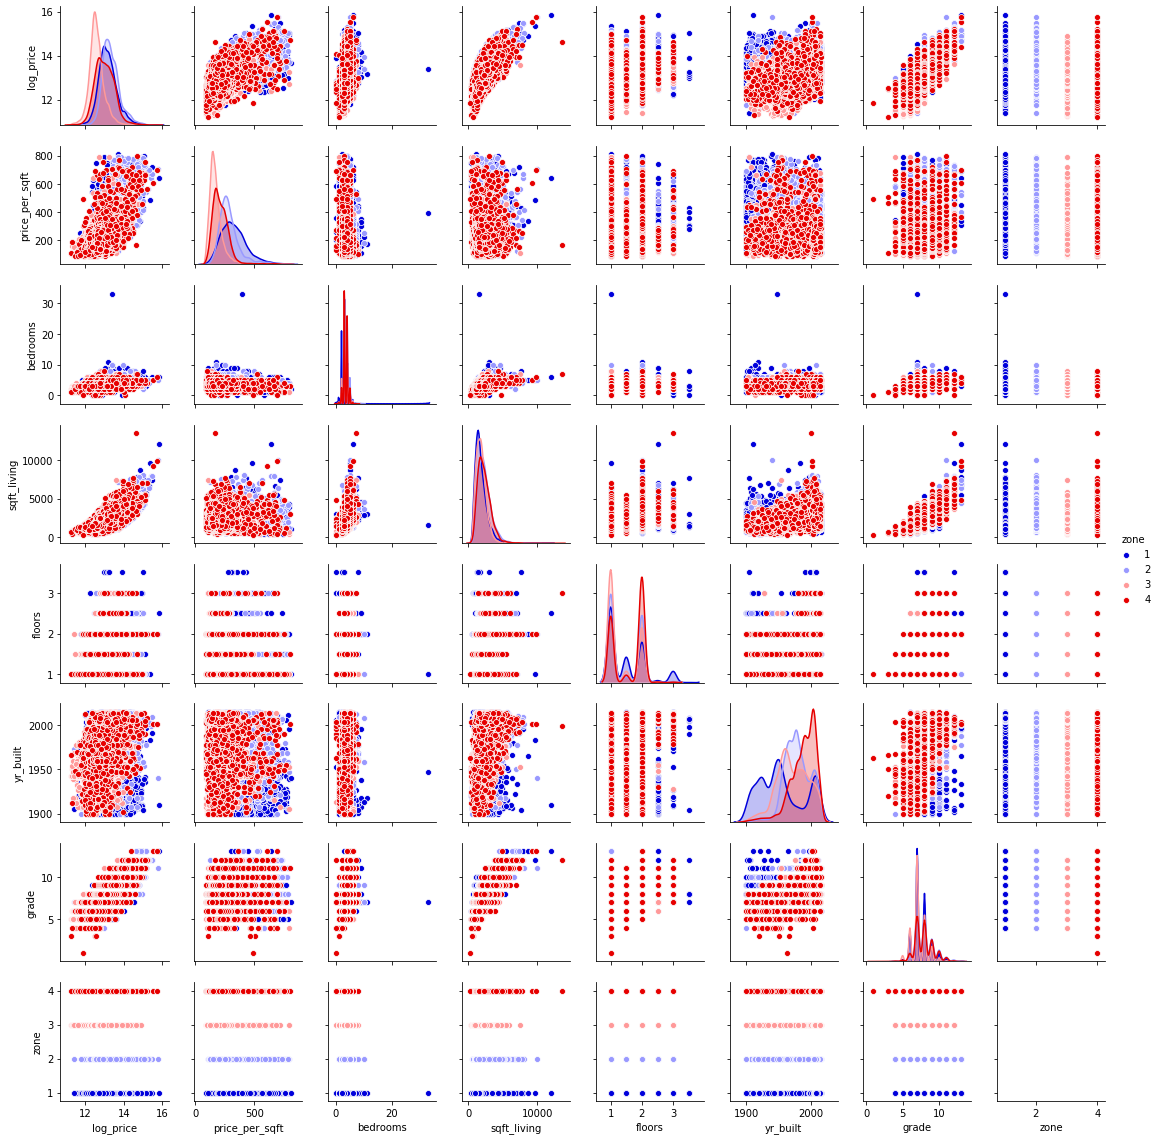

In [8]:
num_cols = ['log_price', 'price_per_sqft', 'bedrooms', 'sqft_living', 'floors', 'yr_built','grade','zone']
sns.pairplot(df.loc[:, num_cols], hue='zone', 
             palette="seismic", diag_kind="kde", 
             size=2)
fig = plt.gcf()
fig.set_size_inches(16,16)
plt.show()

- The auto-correlation of log_price for each grade shows the price increasing trend increasing grade.
- In the price_per_sqft vs price plot, it can be seen that for each grade and price, there is a wide range for price_per_sqft. The reason has to be investigated further but the first guess is it is due to variation in neighborhood of the house. 
- As the grade of the house increases, the area of the house increases; Also the range of the area inncreases.
- Most of the highly graded houses are built around year 2000.  

/Users/reza/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


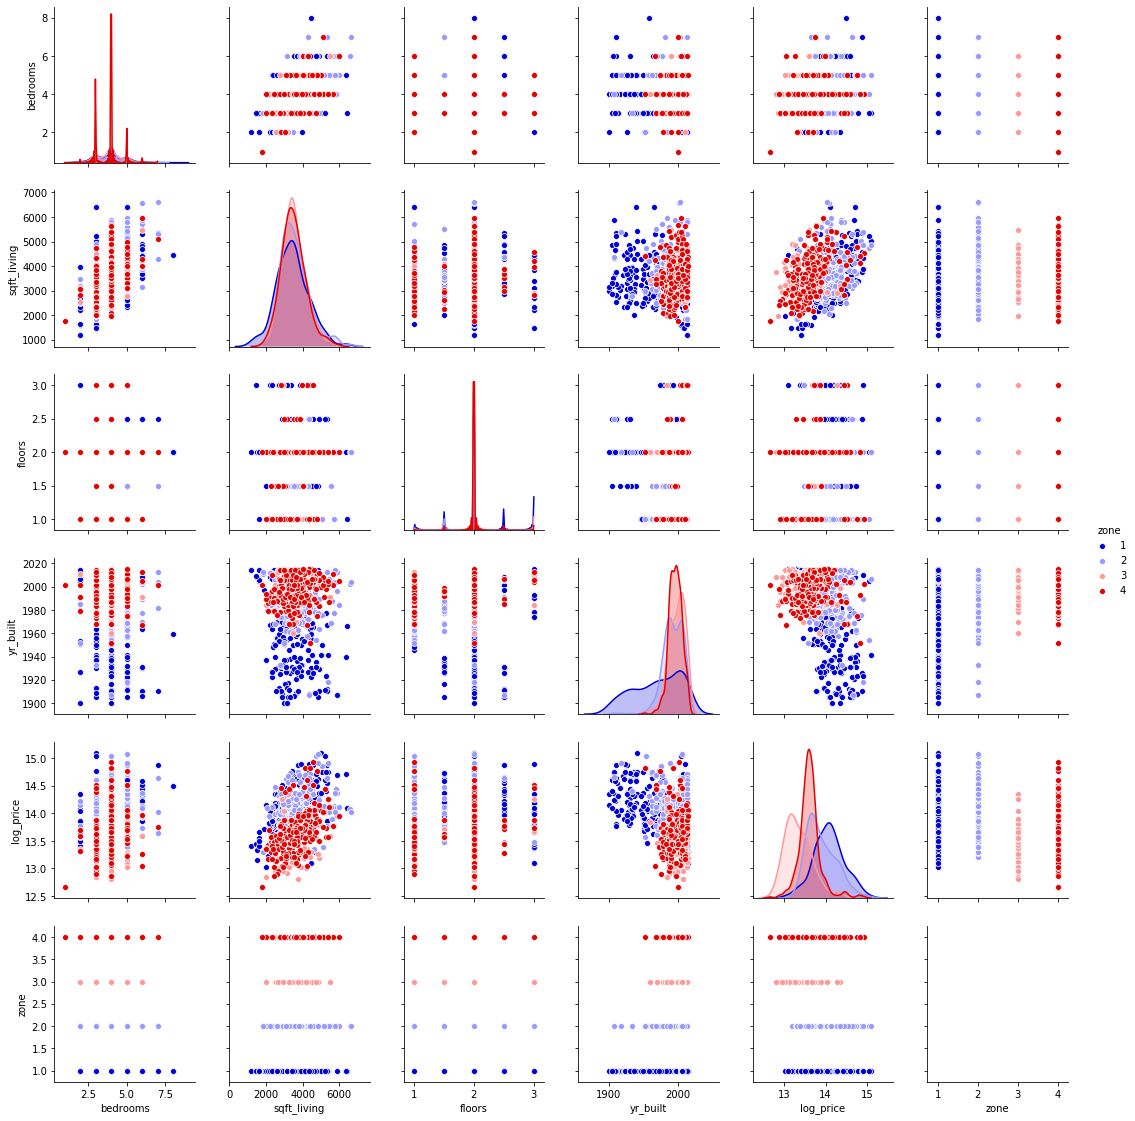

In [9]:
# Create the plots to investigate the effect of zoning of the house on the price of houses with certain grade (10)
# Zone 0 correspond to un-incorporated zipcodes. Further refinement of zoning will be done in future.

df_grade10 = df.loc[df['grade']==10,:]
df_grade10['price_band'] = pd.cut(df_grade10.log_price,[0,10,11,12,13,14,15,16,100])
num_cols = ['bedrooms', 'sqft_living', 'floors', 'yr_built','log_price','zone']
# num_cols = ['log_price', 'price_per_sqft', 'bedrooms', 'sqft_living', 'floors', 'yr_built','price_band']
sns.pairplot(df_grade10.loc[:, num_cols], 
             palette="seismic", diag_kind="kde", hue = 'zone',
             size=2)
fig = plt.gcf()
fig.set_size_inches(16,16)
plt.show()

- Construction in un-incorporated area has started around 1950's and surpassed the construction in incorporated areas in recent years;
-  Price of the houses in un-incorporated areas has narrower range than the other areas.
-  Area of the houses of the same grade are very similar.

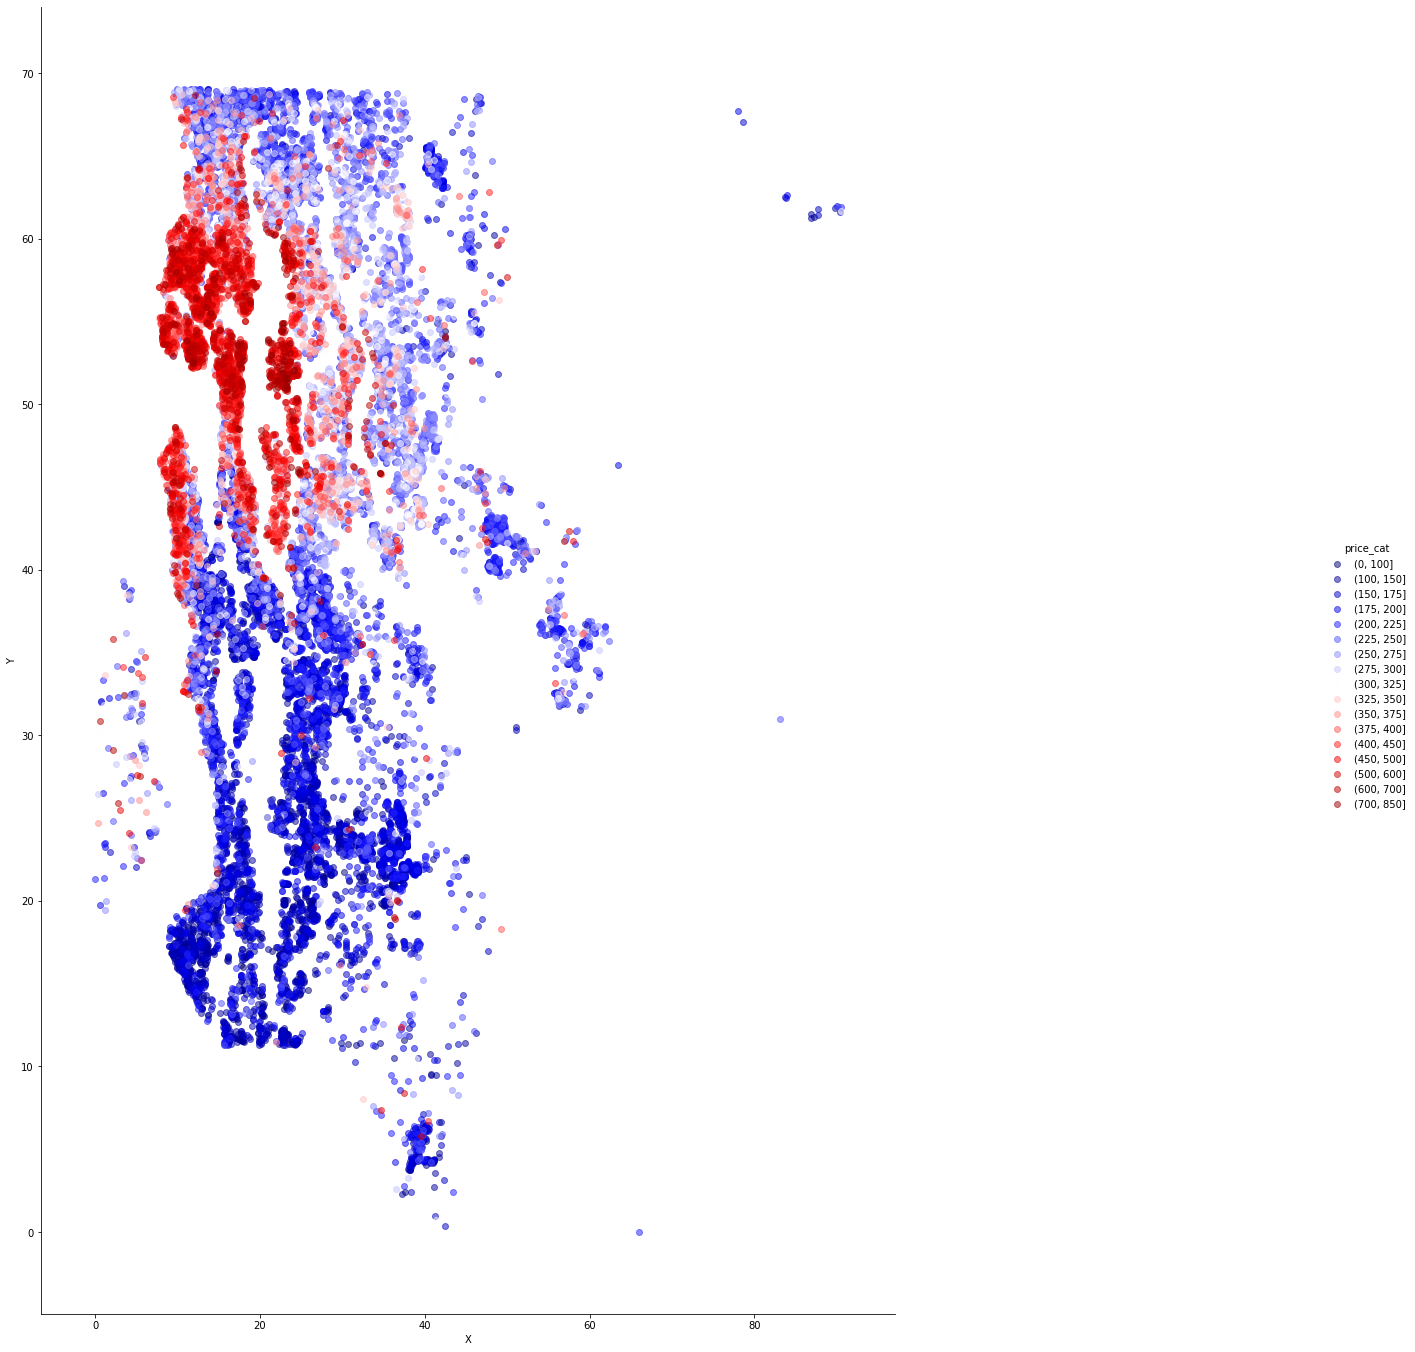

In [10]:
num_cols = ['X', 'Y', 'price_cat']
g = sns.FacetGrid(df, palette="seismic", hue = 'price_cat')
g = (g.map(plt.scatter, 'X','Y', alpha = 0.5 )
     .add_legend())
fig = plt.gcf()
fig.set_size_inches(24,24)
plt.show()

- The above plots show the relationship between house prices, price per square ft, area of the house, number of floors, year of construction of the house, grade and zoning of the house. Shading on the plots is based zoning of the house (1~4).
- The first two diagonal plots (log_price and price_per_sqft) show the distribution of these two parameters for different zones. It is clear from these plots that the house prices and price per square foot of the houses have significant variation between defined zones. 


- The above plot shows geographical location of the houses sold in the entire region. The plot is shaded based on the price category of the houses. The plot shows that the house prices in central regions of the King County (Seattle and Bellevue) are higher than the other regions.

- Average and standard deviation of multiple features for each of the defined zones are calculated.

In [11]:
df.head().T
zone_prop = df.loc[:,['price', 'price_per_sqft','grade','sqft_living','zone']].groupby('zone').agg(['mean','std'])
zone_prop.head()

price                price_per_sqft                 grade  \
               mean            std           mean         std      mean   
zone                                                                      
1     600454.708674  378820.656005     329.639550  109.843161  7.478932   
2     704178.519291  433531.351527     294.099795   97.574025  8.099490   
3     317021.496500  160210.992748     176.280296   60.959521  7.219085   
4     506270.531222  320247.976209     218.311306   76.553400  7.916257   

                sqft_living              
           std         mean         std  
zone                                     
1     1.061200  1857.389602  860.962731  
2     1.231584  2403.718758  982.555763  
3     0.989004  1863.693887  720.993296  
4     1.243591  2318.097579  952.521422

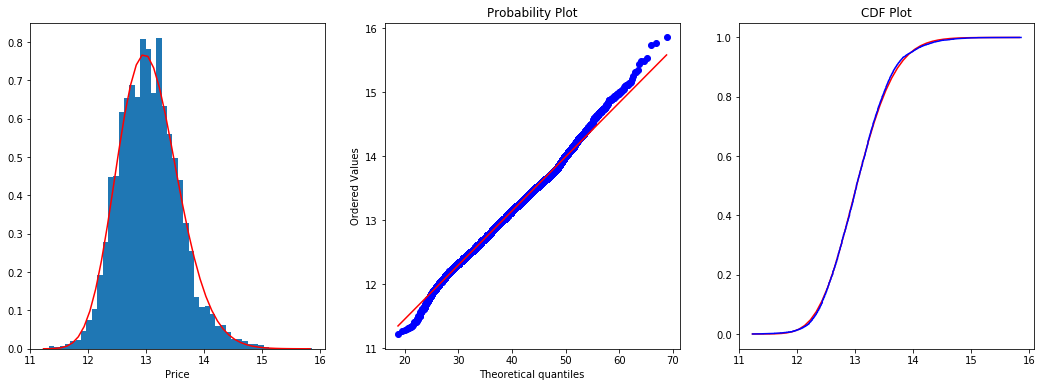

KstestResult(statistic=0.014323285393156193, pvalue=0.0002816211356383854)


In [12]:
# plot histogram and qq-plot of the feature
fig, ax = plt.subplots(1,3, figsize = (18, 6))
ax[0].hist(df['log_price'], bins = 50, density=True) # plot normalized histogram of the feature
ax[0].set_xlabel('Price')

# loc, scale = stats.norm.fit(df['log_price']) # fit normal distribution to the feature
# dist = stats.norm(loc=loc, scale=scale) # create continuous distribution function
alpha ,loc, beta = stats.gamma.fit(df['log_price']) # fit normal distribution to the feature
dist = stats.gamma(alpha, loc=loc, scale = beta) # create continuous distribution function


x = np.arange(df['log_price'].min(), df['log_price'].max(), 0.1)
ax[0].plot(x, dist.pdf(x),'r') # plot pdf of fitted distribution 

plt.sca(ax[1])
# stats.probplot(df['log_price'], dist='norm', plot=plt) # plot qq-plot for the 
stats.probplot(df['log_price'], dist='gamma', sparams=(alpha), plot=plt) # plot qq-plot for the 

ax[2].plot(x, dist.cdf(x),'r')
data_sorted = np.sort(df['log_price'])
p = 1. * np.arange(len(data_sorted)) / (len(data_sorted) - 1)
ax[2].plot(data_sorted,p,'b')
ax[2].set_title('CDF Plot')
plt.show()

KS_test = stats.kstest(df['log_price'],dist.cdf) # perform K-S test for the data and fitted distribution
print(KS_test)

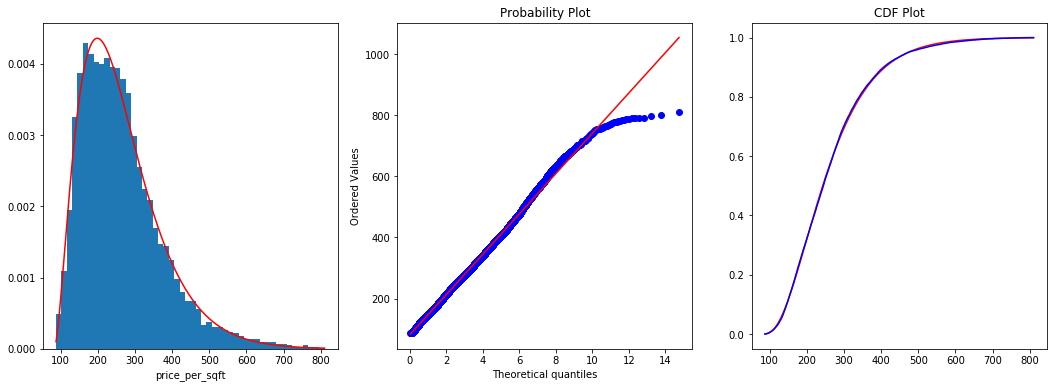

KstestResult(statistic=0.009200989961404393, pvalue=0.05149317810764079)


In [13]:
# plot histogram and qq-plot of the feature
fig, ax = plt.subplots(1,3, figsize = (18, 6))
ax[0].hist(df['price_per_sqft'], bins = 50, density=True) # plot normalized histogram of the feature
ax[0].set_xlabel('price_per_sqft')

# loc, scale = stats.norm.fit(df['price_per_sqft']) # fit normal distribution to the feature
# dist = stats.norm(loc=loc, scale=scale) # create continuous distribution function
alpha ,loc, beta = stats.gamma.fit(df['price_per_sqft']) # fit normal distribution to the feature
dist = stats.gamma(alpha, loc=loc, scale = beta) # create continuous distribution function


x = np.arange(df['price_per_sqft'].min(), df['price_per_sqft'].max(), 0.1)
ax[0].plot(x, dist.pdf(x),'r') # plot pdf of fitted distribution 

plt.sca(ax[1])
# stats.probplot(df['price_per_sqft'], dist='norm', plot=plt) # plot qq-plot for the 
stats.probplot(df['price_per_sqft'], dist='gamma', sparams=(alpha), plot=plt) # plot qq-plot for the 

ax[2].plot(x, dist.cdf(x),'r')
data_sorted = np.sort(df['price_per_sqft'])
p = 1. * np.arange(len(data_sorted)) / (len(data_sorted) - 1)
ax[2].plot(data_sorted,p,'b')
ax[2].set_title('CDF Plot')
plt.show()

KS_test = stats.kstest(df['price_per_sqft'],dist.cdf) # perform K-S test for the data and fitted distribution
print(KS_test)

In [ ]:
# plot histogram and qq-plot of the feature
fig, ax = plt.subplots(1,3, figsize = (18, 6))
ax[0].hist(np.log(df['sqft_living']), bins = 50, density=True) # plot normalized histogram of the feature
ax[0].set_xlabel('sqft_living')

loc, scale = stats.norm.fit(np.log(df['sqft_living'])) # fit normal distribution to the feature
dist = stats.norm(loc=loc, scale=scale) # create continuous distribution function
# alpha ,loc, beta = stats.lognorm.fit(df['sqft_living']) # fit normal distribution to the feature
# dist = stats.gamma(alpha, loc=loc, scale = beta) # create continuous distribution function


x = np.arange(np.log(df['sqft_living']).min(), np.log(df['sqft_living']).max(), 0.1)
ax[0].plot(x, dist.pdf(x),'r') # plot pdf of fitted distribution 

plt.sca(ax[1])
stats.probplot(np.log(df['sqft_living']), dist='norm', plot=plt) # plot qq-plot for the 
# stats.probplot(df['sqft_living'], dist='gamma', sparams=(alpha), plot=plt) # plot qq-plot for the 

ax[2].plot(x, dist.cdf(x),'r')
data_sorted = np.sort(np.log(df['sqft_living']))
p = 1. * np.arange(len(data_sorted)) / (len(data_sorted) - 1)
ax[2].plot(data_sorted,p,'b')
ax[2].set_title('CDF Plot')
plt.show()

KS_test = stats.kstest(np.log(df['sqft_living']),dist.cdf) # perform K-S test for the data and fitted distribution
print(KS_test)

### Compute basic summary statistics and their confidence interval by classical, bootstrap and Bayesian methods

#### a) Classical Method

zone= 1 Mean Price= 600454.71 Std= 378820.66
zone= 2 Mean Price= 704178.52 Std= 433531.35
zone= 3 Mean Price= 317021.50 Std= 160210.99
zone= 4 Mean Price= 506270.53 Std= 320247.98


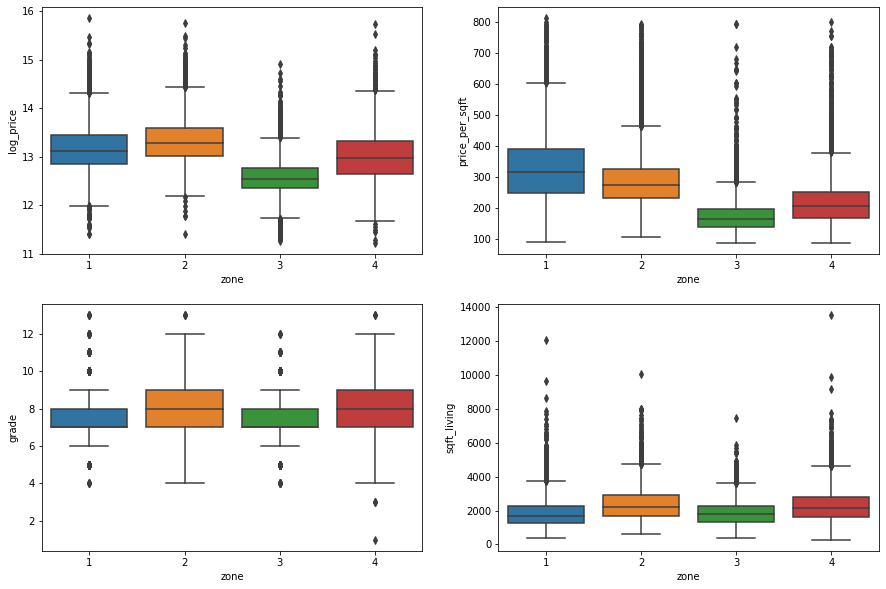

In [14]:
plot_features = ['log_price', 'price_per_sqft','grade','sqft_living']
fig, ax = plt.subplots(2,2,figsize=(15,10))
ax = np.reshape(ax,4)
for i in range(len(plot_features)):
    sns.boxplot(data=df,x='zone',y=plot_features[i], ax=ax[i] )
    
mean_data = df.loc[:,['zone','price']].groupby('zone').agg('mean')
std_data = df.loc[:,['zone','price']].groupby('zone').agg('std')

for group in mean_data.index:
    print('zone= %d Mean Price= %.2f Std= %.2f' % (group, mean_data.loc[group,:], std_data.loc[group,:]))

#### b) Bootstrap Method

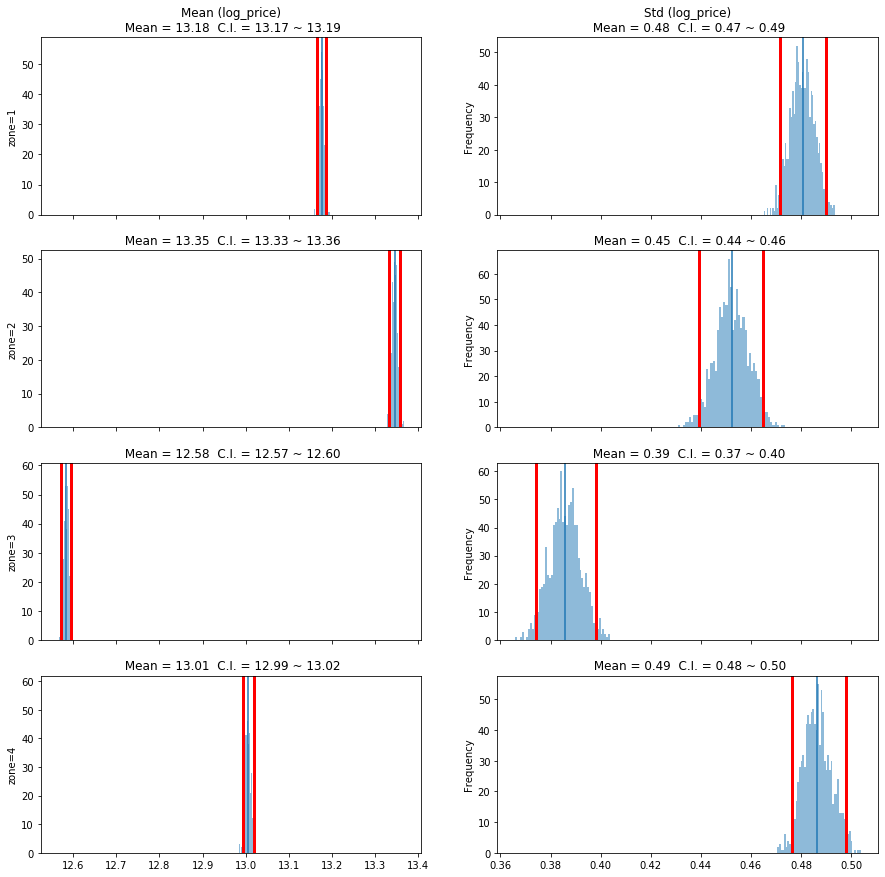

In [15]:
def plot_hist(x, p=5):
    # Plot the distribution and mark the mean
    x.plot.hist(alpha=.5, bins = 50)
    mean_sample = x.mean()
    plt.axvline(mean_sample)
    # 95% confidence interval    
    ci_lower = np.percentile(x, p/2.)
    ci_upper = np.percentile(x, 100-p/2.)
    plt.axvline(ci_lower, color='red', linewidth=3)
    plt.axvline(ci_upper, color='red', linewidth=3)
    return mean_sample, ci_lower, ci_upper

# Create dataframes with columns as the insurance symbol and rows as the mean or standard deviation of the sample
n_replicas = 1000
mean_data_bs = pd.DataFrame(columns = [1,2,3,4])
std_data_bs = pd.DataFrame(columns = [1,2,3,4])
for i in range(n_replicas):
    for zone in mean_data_bs.columns:
        sample = df.loc[df['zone']==zone,['zone','log_price']].sample(frac=1.0, replace=True)
        mean_data_bs.loc[i,zone] = sample.mean().log_price
        std_data_bs.loc[i,zone] = sample.std().log_price


# plot mean and standard deviation distribution of samples
fig1,ax1 = plt.subplots(len(mean_data_bs.columns),2, sharex='col', figsize=(15,15))
for i,symbol in enumerate(mean_data_bs.columns):
    plt.sca(ax1[i,0])
    mean_m, ci_lower_m, ci_upper_m = plot_hist(mean_data_bs.loc[:,symbol])
    
    ax1[i,0].set_ylabel('zone=%d'%symbol)
    plt.sca(ax1[i,1])
    mean_s, ci_lower_s, ci_upper_s = plot_hist(std_data_bs.loc[:,symbol])
    if i==0:
        text1 = 'Mean (log_price)\n'
        text2 = 'Std (log_price)\n'
    else:
        text1 = ''
        text2 = ''
    ax1[i,0].set_title('%s Mean = %.2f  C.I. = %.2f ~ %.2f'% (text1, mean_m, ci_lower_m, ci_upper_m))
    ax1[i,1].set_title('%s Mean = %.2f  C.I. = %.2f ~ %.2f'% (text2, mean_s, ci_lower_s, ci_upper_s))
    

#### c) Bayesian Method

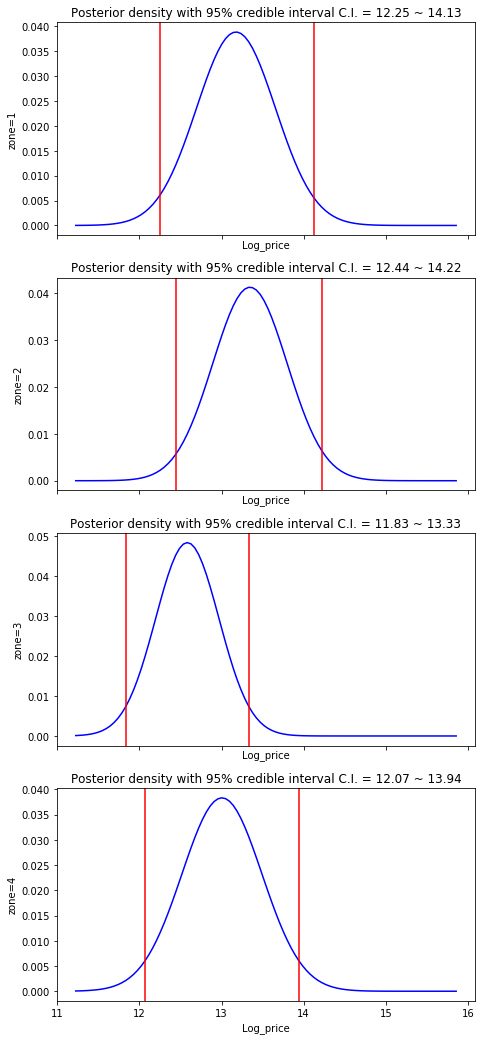

In [16]:
import scipy

def likelihood(p, data):
    loc = data.mean()
    scale = data.std()
    # Compute normal
    dist = stats.norm(loc=loc, scale=scale)
    l = dist.pdf(p)
    # Normalize the likelihood to sum to unity
    return l/sum(l)

def posterior(prior, like):
    post = prior * like # compute the product of the probabilities
    return post / sum(post) # normalize the distribution to sum to unity

def plot_post(prior, like, post, x):
    maxy = max(max(prior), max(like), max(post))
    plt.figure(figsize=(12, 4))
    plt.plot(x, like, label='likelihood', linewidth=12, color='black', alpha=.2)
    plt.plot(x, prior, label='prior')
    plt.plot(x, post, label='posterior', color='green')
    plt.ylim(0, maxy)
    plt.title('Density of prior, likelihood and posterior')
    plt.ylabel('Density')
    plt.legend()


def plot_ci(p, post, num_samples, lower_q, upper_q):
    ## This function computes a credible interval using an assumption
    ## of symetry in the bulk of the distribution to keep the 
    ## calculation simple. 
    ## Compute a large sample by resampling with replacement
    samples = np.random.choice(p, size=num_samples, replace=True, p=post)
    ci = scipy.percentile(samples, [lower_q*100, upper_q*100]) # compute the quantiles
    interval = upper_q - lower_q
    plt.plot(p, post, color='blue')
    plt.xlabel('Parameter value')
    plt.ylabel('Density')
    plt.axvline(x=ci[0], color='red')
    plt.axvline(x=ci[1], color='red')
    return ci

    
df_grouped = df.loc[:,['zone', 'log_price']].groupby('zone')    
num_samples = 1000000
symbol = 3
i=0
N = 100
min_price = df_grouped.log_price.min().min()
max_price = df_grouped.log_price.max().max()
p = np.linspace(min_price, max_price, num=N)
pp = [1./N] * N
fig, ax = plt.subplots(4,1, figsize =(7.5, 18), sharex=True)

for i, symbol in enumerate([1,2,3,4]):
    p = np.linspace(min_price, max_price, num=N)
    pp = [1./N] * N
    l = likelihood(p, df.loc[df['zone']==symbol,'log_price'])
    post = posterior(pp, l)
    lower_q, upper_q = [.025, .975]
    plt.sca(ax[i])
    ci = plot_ci(p, post, num_samples, lower_q, upper_q)
    ax[i].set_ylabel('zone=%d'%symbol)
    ax[i].set_title('Posterior density with 95%% credible interval C.I. = %.2f ~ %.2f'% (ci[0],ci[1]))
    ax[i].set_xlabel('Log_price')

## Leverage confidence intervals in performing hypothesis tests to determine if the differences in pairs and multiple populations are significant

#### a) Log_Price 
Tukey's Anova test is performed to test if there is significant price difference between house prices in different zones.

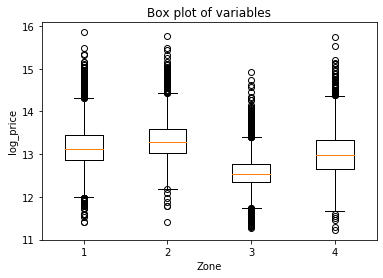

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
zone-1 zone-2   0.1702 0.001  0.1474   0.193   True
zone-1 zone-3  -0.5925 0.001  -0.615   -0.57   True
zone-1 zone-4  -0.1709 0.001 -0.1917   -0.15   True
zone-2 zone-3  -0.7627 0.001 -0.7885 -0.7369   True
zone-2 zone-4  -0.3411 0.001 -0.3654 -0.3167   True
zone-3 zone-4   0.4216 0.001  0.3975  0.4457   True
---------------------------------------------------


In [17]:
zone1 = df.loc[df['zone']==1,'log_price']
zone2 = df.loc[df['zone']==2,'log_price']
zone3 = df.loc[df['zone']==3,'log_price']
zone4 = df.loc[df['zone']==4,'log_price']

# plot box plot of log_price
plt.boxplot([zone1, zone2, zone3, zone4])
plt.ylabel('log_price')
plt.xlabel('Zone')
plt.title('Box plot of variables')
ax = plt.gca()
ax.set_xticklabels(np.arange(1,5))
plt.show()

# Tukey's ANOVA Test
from statsmodels.stats.multicomp import pairwise_tukeyhsd
zones = pd.DataFrame({'vals': list(zone1) + list(zone2) + list(zone3) + list(zone4),
                   'group_num': ['zone-1'] * zone1.shape[0] + ['zone-2'] * zone2.shape[0] + 
                     ['zone-3'] * zone3.shape[0] + ['zone-4'] * zone4.shape[0]})

Tukey_HSD = pairwise_tukeyhsd(zones.vals, zones.group_num)
print(Tukey_HSD)

- Based on Tukey's HSD test, we can reject the null hypothesis that zone-1 through zone-4 have the same sample mean.

#### b) sqft_living

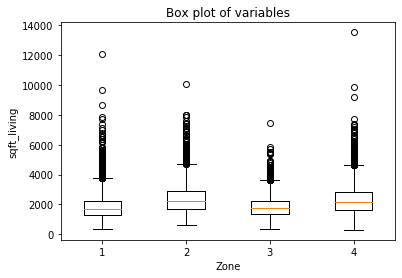

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj   lower     upper   reject
--------------------------------------------------------
zone-1 zone-2  546.3292 0.001  502.4825  590.1758   True
zone-1 zone-3    6.3043   0.9  -36.9888   49.5974  False
zone-1 zone-4   460.708 0.001  420.5887  500.8273   True
zone-2 zone-3 -540.0249 0.001 -589.6015 -490.4482   True
zone-2 zone-4  -85.6212 0.001 -132.4518  -38.7906   True
zone-3 zone-4  454.4037 0.001   408.091  500.7164   True
--------------------------------------------------------


In [18]:
zone1 = df.loc[df['zone']==1,'sqft_living']
zone2 = df.loc[df['zone']==2,'sqft_living']
zone3 = df.loc[df['zone']==3,'sqft_living']
zone4 = df.loc[df['zone']==4,'sqft_living']

# plot box plot of log_price
plt.boxplot([zone1, zone2, zone3, zone4])
plt.ylabel('sqft_living')
plt.xlabel('Zone')
plt.title('Box plot of variables')
ax = plt.gca()
ax.set_xticklabels(np.arange(1,5))
plt.show()

# Tukey's ANOVA Test
from statsmodels.stats.multicomp import pairwise_tukeyhsd
zones = pd.DataFrame({'vals': list(zone1) + list(zone2) + list(zone3) + list(zone4),
                   'group_num': ['zone-1'] * zone1.shape[0] + ['zone-2'] * zone2.shape[0] + 
                     ['zone-3'] * zone3.shape[0] + ['zone-4'] * zone4.shape[0]})

Tukey_HSD = pairwise_tukeyhsd(zones.vals, zones.group_num)
print(Tukey_HSD)

#### c) price_per_sqft

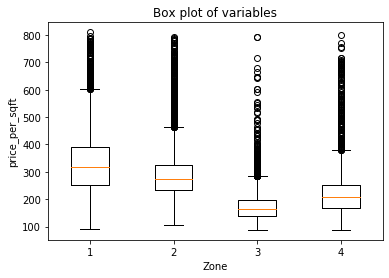

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj   lower     upper   reject
--------------------------------------------------------
zone-1 zone-2  -35.5398 0.001  -40.0691  -31.0104   True
zone-1 zone-3 -153.3593 0.001 -157.8314 -148.8871   True
zone-1 zone-4 -111.3282 0.001 -115.4725 -107.1839   True
zone-2 zone-3 -117.8195 0.001 -122.9407 -112.6983   True
zone-2 zone-4  -75.7885 0.001  -80.6261  -70.9509   True
zone-3 zone-4    42.031 0.001   37.2469   46.8151   True
--------------------------------------------------------


In [19]:
zone1 = df.loc[df['zone']==1,'price_per_sqft']
zone2 = df.loc[df['zone']==2,'price_per_sqft']
zone3 = df.loc[df['zone']==3,'price_per_sqft']
zone4 = df.loc[df['zone']==4,'price_per_sqft']

# plot box plot of log_price
plt.boxplot([zone1, zone2, zone3, zone4])
plt.ylabel('price_per_sqft')
plt.xlabel('Zone')
plt.title('Box plot of variables')
ax = plt.gca()
ax.set_xticklabels(np.arange(1,5))
plt.show()

# Tukey's ANOVA Test
from statsmodels.stats.multicomp import pairwise_tukeyhsd
zones = pd.DataFrame({'vals': list(zone1) + list(zone2) + list(zone3) + list(zone4),
                   'group_num': ['zone-1'] * zone1.shape[0] + ['zone-2'] * zone2.shape[0] + 
                     ['zone-3'] * zone3.shape[0] + ['zone-4'] * zone4.shape[0]})

Tukey_HSD = pairwise_tukeyhsd(zones.vals, zones.group_num)
print(Tukey_HSD)

- Based on Tukey's HSD test, we can reject the null hypothesis that the price per sqft of the houses in zone-1 through zone-4 have the same sample mean.

### Create Linear Regression Model of Data

- Linear regression model of the original data is created. 

log_price ~ 1 +waterfront + bedrooms + bathrooms + sqft_living + sqft_lot + floors + view + condition + grade + yr_built + zone1 + zone2 + zone3
Intercept, Slopes : 
Intercept      12.947823
waterfront      0.442260
bedrooms       -0.011573
bathrooms       0.038723
sqft_living     0.186887
sqft_lot        0.012868
floors          0.023023
view            0.039550
condition       0.028401
grade           0.200921
yr_built       -0.084945
zone1           0.256601
zone2           0.267629
zone3          -0.231681
dtype: float64
Intercept t-value, Slope t-values: 
Intercept      3474.989078
waterfront       20.137102
bedrooms         -5.195409
bathrooms        12.457714
sqft_living      52.051649
sqft_lot          7.098384
floors           10.230825
view             19.588880
condition        15.029303
grade            66.642525
yr_built        -32.186474
zone1            48.110151
zone2            49.504864
zone3           -42.750222
dtype: float64

Hypothesis test summary for each coeffi

Text(0.5, 1.0, 'Residual Histogram')

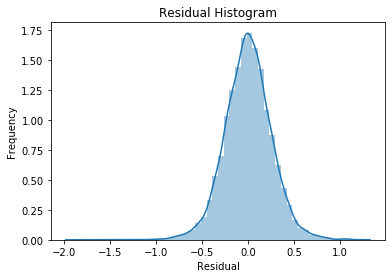

In [22]:
# Drop unneccessary columns
df = df.loc[:,['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot','floors', 'waterfront', 'view', 'condition','grade','yr_built','zone','log_price']]

# Scale bedrooms, bathrooms, sqft_living, sqft_lot, condition, grade and year built columns
def scale(col):
    mean = np.mean(col)
    std = np.std(col)
    return (col-mean)/std

categorical_columns = ['waterfront', 'zone']
output_column = ['log_price']

X_data=pd.DataFrame()
X_data[['waterfront']]=df[['waterfront']]

for column in df.columns:
    if column not in categorical_columns+output_column:
        X_data.loc[:,column] = scale(df.loc[:,column])
        
dummies = pd.get_dummies(df.loc[:, 'zone'])
X_data[['zone1','zone2','zone3']] = dummies.iloc[:,:-1]

Y_data = df['log_price']
df_scaled = X_data.join(Y_data)
# fitting linear regression model to scaled data
formula_string = 'log_price ~ 1 +' + ' + '.join(x for x in X_data.columns)
print(formula_string)
ols_model = sm.ols(formula = formula_string, data=df_scaled)

results = ols_model.fit()
n_points = df_scaled.shape[0]
y_output = df_scaled['log_price'].values.reshape(n_points, 1)

# Get slope (m) and y-intercept (b)
print('Intercept, Slopes : \n{}'.format(results.params))

# Get the t-values (hypothesis test statistics) for linear regression coefficient hypothesis tests.
print('Intercept t-value, Slope t-values: \n{}'.format(results.tvalues))

# Get p-values for above t-value statistics
print('\nHypothesis test summary for each coefficient if they differ from zero:')
print(results.pvalues)

print('\nSSE, SST, SSR, and RMSE:')
mean_y = np.mean(y_output)
sst = np.sum((y_output - mean_y)**2)
sse = sst - results.ssr
print('SSE: {}'.format(sse))
print('SST: {}'.format(sst))
print('SSR: {}'.format(results.ssr))
print('RMSE: {}'.format(np.sqrt(results.mse_model)))

# # Get most of the linear regression statistics we are interested in:
print(results.summary())

# # Plot a histogram of the residuals
sns.distplot(results.resid, hist=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residual Histogram')

- The P-values and confidence intervals of the intercept and coefficients indicate that all the features have significant impact on the price of the house. Adjusted R-squared value of 0.766 shows that model produces relatively reasonable results.
- The residuals have normal distribution and relatively small values.

### Create Principal Component Regression Model

- For this model, PCA is performed to extract the principal components of the data. 
- Linear regression model is then fitted to the principal components.

In [23]:
# Perform PCA regression on the data
from sklearn.decomposition import PCA
pca = PCA(n_components=13)
pca_result = pca.fit_transform(X_data)
pca_df = pd.DataFrame(data = pca_result , columns = ['pc{}'.format(i) for i in range(1,14)])
pca_df['log_price'] = df['log_price']
# print variance ratio for each principal component
print('PCA Explained Varaince Ratio:\n')
print(pca.explained_variance_ratio_)
# Print cumulative sum of variance ratio to find the minimum number of principal componenets that can explain 95% of variance
print('\nPCA Cumulative Sum of Explained Varaince Ratio:\n')
print(np.cumsum(pca.explained_variance_ratio_))

PCA Explained Varaince Ratio:

[0.37228785 0.15073704 0.10636862 0.09734602 0.07335067 0.05825511
 0.05039162 0.02987844 0.0220169  0.01836365 0.01491418 0.00543903
 0.00065088]

PCA Cumulative Sum of Explained Varaince Ratio:

[0.37228785 0.52302489 0.62939351 0.72673953 0.8000902  0.85834531
 0.90873693 0.93861536 0.96063226 0.97899591 0.99391009 0.99934912
 1.        ]


- From above results, the first 9 principal components explain more than 95% of the variance of the price.

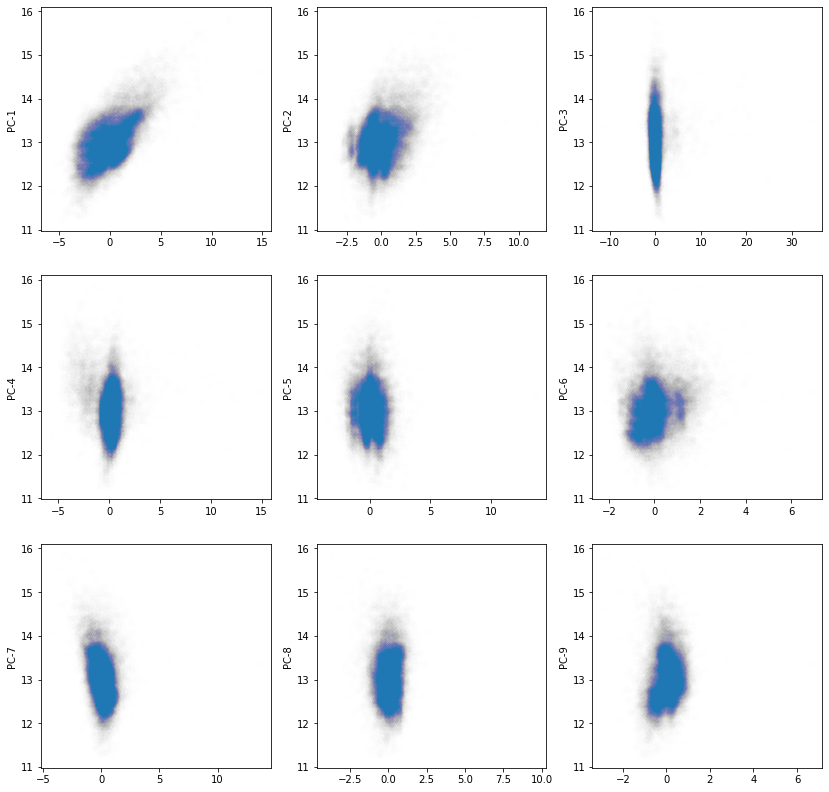

In [24]:
# Plot significant principal components (first 9) against target variable (log_price)
fig, ax = plt.subplots(3,3,figsize=(14,14))
ax2 = ax.reshape(1,9)
for i in range(9):
    ax2[0,i].scatter(pca_df.iloc[:,i],pca_df['log_price'],alpha=0.002)
    ax2[0,i].set_ylabel('PC-{}'.format(i+1))


                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     5444.
Date:                Tue, 05 May 2020   Prob (F-statistic):               0.00
Time:                        10:57:24   Log-Likelihood:                -1106.3
No. Observations:               21613   AIC:                             2241.
Df Residuals:                   21599   BIC:                             2352.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.0478      0.002   7529.421      0.0

Text(0.5, 1.0, 'Residual Histogram')

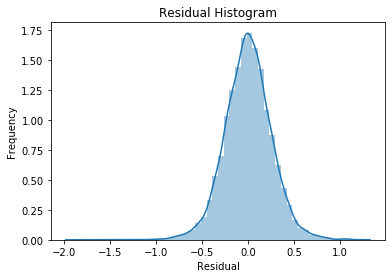

In [25]:
pcr_model = sm.ols(formula = 'log_price ~ 1 + pc1 + pc2 + pc3 + pc4 + pc5 + pc6 + pc7 + pc8 + pc9 + pc10 + pc11 + pc12 + pc13', data=pca_df)

results = pcr_model.fit()
n_points = pca_df.shape[0]
y_output = pca_df['log_price'].values.reshape(n_points, 1)

# Get most of the linear regression statistics we are interested in:
print(results.summary())

# Plot a histogram of the residuals
sns.distplot(results.resid, hist=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residual Histogram')

- The P-values and confidence intervals of the intercept and coefficients indicate that all principal components have significant impact on the price of the house. Adjusted R-squared value of 0.766 shows that model produces relatively reasonable results.
- The residuals have normal distribution and relatively small values.